In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def Open_file(file_name):
    
    df = pd.read_csv(file_name, header=None,sep='\t' )
    new_df = df.drop(axis = 1, columns = [0,1])
    df_array = new_df.to_numpy()
    
    return [df, df_array]

In [3]:
def similarity_matrix(df_array,sigma):
    graph_array = np.zeros([len(df_array), len(df_array)])
    for i in range(len(df_array)):
        for j in range(len(df_array)):
            temp_dist = np.linalg.norm(df_array[i] - df_array[j])
            graph_array[i,j] = np.exp((-temp_dist**2)/(sigma**2))
    return graph_array

In [4]:
def laplace_matrix_cal(df_array, sigma):
    # similarity matrix
    df_array_dst = similarity_matrix(df_array, sigma)

    # Diagonal Matrix Calculation
    diagonal_matrix = np.zeros([len(df_array_dst), len(df_array_dst)])
    diagonal_matrix_values = np.sum(df_array_dst, axis = 1) # Row wise sum
    for i in range(len(df_array_dst)):
        diagonal_matrix[i,i] = diagonal_matrix_values[i]

    # laplace matrix calculation
    laplace_matrix = diagonal_matrix - df_array_dst
    return laplace_matrix

In [5]:
def sorting_eig_values(laplace_matrix):
    
    eig_values, eig_vectors = np.linalg.eig(laplace_matrix)
    index = np.argsort(eig_values)
    max_diff = 0
    max_diff_index = int
    temp = []
    for i in range(0,len(index)-1):
        temp = (abs(eig_values[index[i]] - eig_values[index[i+1]]))
        if temp > max_diff :
            max_diff = temp
            max_diff_index = i+1

    new_index = index[:max_diff_index+1]
    input_kmeans = eig_vectors[:,new_index]
    return input_kmeans

# Kmeans


In [6]:
def Kmeans(number_clusters, num_iterations, centroids, standard_new_df):
    while(num_iterations>0):
        num_iterations-=1
        
        dist_matrix = np.ones([standard_new_df.shape[0], number_clusters])
        cluster_dct = {i:[] for i in range(number_clusters)}

        for i in range(standard_new_df.shape[0]):
            minimum_value, cluster = float('inf'), -1
            for j in range(number_clusters):
                dist_matrix[i][j] = pdist([standard_new_df[i], centroids[j]])[0]
                if minimum_value>dist_matrix[i][j]:
                    cluster = j
                    minimum_value = dist_matrix[i][j]
            cluster_dct[cluster].append(i)

        for key in cluster_dct.keys():
            centroids[key] = np.mean(standard_new_df[cluster_dct[key]], axis=0)
        return cluster_dct

In [7]:
def cluster_allotment(dct, df): 
    i, cluster_dct = 1, dct
    for key in cluster_dct.keys():
        for val in cluster_dct[key]:
            df.loc[val,'cluster_gen'] = int(i)
        i+=1

    ground_cluster = df.iloc[:,1]
    cluster_gen = df.iloc[:,-1]
    return jac_rand(ground_cluster, cluster_gen)
    

In [8]:
# Clustering Validation
def jac_rand(ground_cluster, cluster_gen):

    cluster1, cluster2 = ground_cluster, cluster_gen
    m_1_1=0
    m_0_0=0
    m_0_1=0
    m_1_0=0

    inc_m_g = np.empty([len(ground_cluster),len(ground_cluster)])
    inc_m_c = np.empty([len(ground_cluster),len(ground_cluster)])

    for i in range(len(ground_cluster)):
        for j in range(len(ground_cluster)):
            inc_m_g[i,j] = 1 if cluster1[i]==cluster1[j] else 0
            inc_m_c[i,j] = 1 if cluster2[i]==cluster2[j] else 0
            if inc_m_g[i,j]==1 and inc_m_c[i,j]==1:
                m_1_1+=1
            elif inc_m_g[i,j]==0 and inc_m_c[i,j]==0:
                m_0_0+=1
            elif inc_m_g[i,j]==1 and inc_m_c[i,j]==0:
                m_1_0+=1
            else:
                m_0_1+=1
    jaccard = m_1_1/(m_1_1 + m_0_1 + m_1_0)
    rand = (m_1_1 + m_0_0)/(m_1_1 + m_0_1 + m_1_0 + m_0_0)
    return (jaccard, rand)

In [9]:
def pca_inbuilt(file):

    file = file.iloc[:,1:]
    file.rename(columns = {1:'Ground_Truth'}, inplace = True)
    
    target = file["cluster_gen"]
    inputs_copy = file.drop(['cluster_gen', 'Ground_Truth'], axis='columns')
    pca = PCA(n_components=2)
    pca_dim = pca.fit_transform(inputs_copy.to_numpy())
    pca_df = pd.DataFrame(pca_dim)
    pca_df.rename(columns = {0:'PCA_1',1:'PCA_2'}, inplace = True)
    pca_df["Target"] = target
    labels = set(pca_df['Target'])
    plt.figure(figsize = (12,12))
    for label in labels:
        index = pca_df['Target'] == label
        plt.plot(pca_df['PCA_1'][index], pca_df['PCA_2'][index],linestyle='none', marker='o', label=label)
        plt.xlabel('PCA_1', fontsize=18)
        plt.ylabel('PCA_2', fontsize=18)
    plt.legend(numpoints=1, fontsize=18)
    plt.title("PCA", fontsize=18)
    plt.show()

**Run the below cell and give the necessary inputs.**

Enter the name of the file : new_dataset_1.txt
Enter the sigma value to build a fully connected graph : 2
Enter the number of clusters : 3
Enter the number of iterations : 300
Enter the index of the initial centroids with spaces in between : 1 4 8
Jaccard :  0.4985530546623794
Rand :  0.7227555555555556


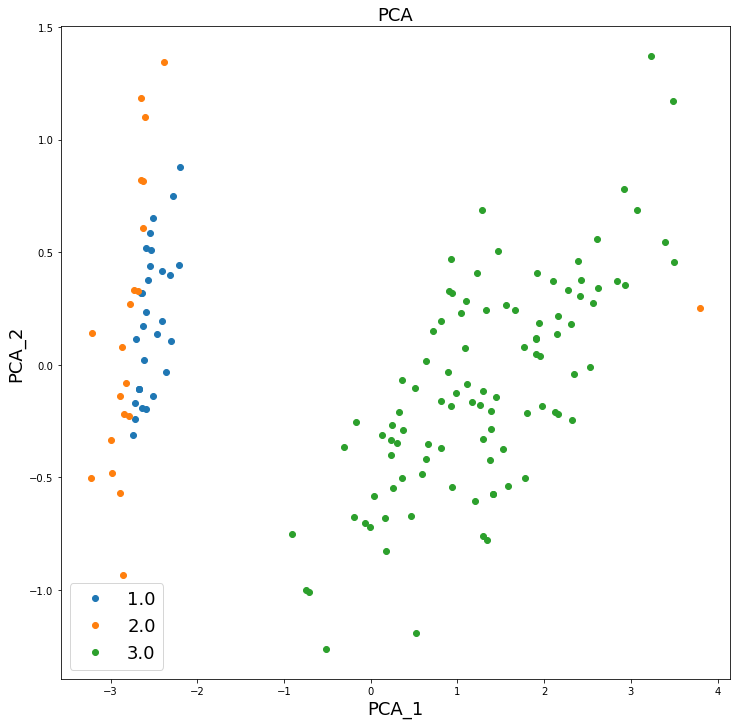

In [12]:
file_name = input('Enter the name of the file : ')
sigma = float(input('Enter the sigma value to build a fully connected graph : '))
number_clusters = int(input('Enter the number of clusters : '))
num_iterations = int(input('Enter the number of iterations : '))
centroids = input("Enter the index of the initial centroids with spaces in between : ")

df, df_array = Open_file(file_name)
laplace_matrix = laplace_matrix_cal(df_array, sigma)
final_matrix = sorting_eig_values(laplace_matrix)

lst_centroid_index = centroids.split()
lst_centroid_int_index = [int(i)-1 for i in lst_centroid_index]

centroids = final_matrix[lst_centroid_int_index,:]
dct = Kmeans(number_clusters, num_iterations, centroids, final_matrix)

jaccard, rand = cluster_allotment(dct, df)
print('Jaccard : ',jaccard)
print('Rand : ',rand)

pca_inbuilt(df)
